### Imports

In [1]:

import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
import re

### Read packets processed by the switch and the number of packets sent to the NIDS

In [2]:
def read_sw_info(filepath):
    packets_processed, packets_cloned = 0, 0
    try:
        with open(filepath) as file:
            previous_line = ""
            get_cloned_data, get_processed_data = False, False
            for line in file:
                if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 2" in line:
                    get_cloned_data = True

                if "packet_count" in line and get_cloned_data == True:
                    packets_cloned = int(line.split()[1])
                    get_cloned_data = False

                if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 3" in line:
                    get_processed_data = True

                if "packet_count" in line and get_processed_data == True:
                    packets_processed = int(line.split()[1])
                    get_processed_data = False

                previous_line = line
    except Exception as e:
        print(e)
    return packets_cloned, packets_processed

### Read amount of alerts

In [3]:
def read_alerts_info(filepath):
    num_lines = 0
    protocol_count = {}
    with open(filepath) as file:
        for line in file:
            num_lines+=1
            try:
                proto = re.search('proto\" : \"(.+?)\",', line).group(1)
                if proto in protocol_count:
                    protocol_count[proto]+=1
                else:
                    protocol_count[proto]=1
            except AttributeError as e:
                print(e)
        
    return num_lines, protocol_count

### Read number of processed packets by Snort

In [4]:
def read_Snort_info(filepath):
    packets_received_Snort= 0 
    with open(filepath) as csvfile:
        csv_file = pd.read_csv(csvfile)
        packets_received_Snort = csv_file["daq.received"].sum()

    return packets_received_Snort     

### Read the folder containing all experiments

In [5]:
input_folder = "/home/ubuntu/p4-ddos/brum-p4/results/rules_analysis"

data = []
for scenario in os.listdir(input_folder):
    if os.path.isfile(os.path.join(input_folder, scenario)):
        continue

    for experiment_round in os.listdir(os.path.join(input_folder, scenario)):
        
        if "1" not in experiment_round: # Read only one round of each pcap
            continue

        exp = experiment_round.split("_")
        abs_path = os.path.join(input_folder, scenario, experiment_round)

        packets_cloned, packets_processed = read_sw_info(os.path.join(abs_path, "stdout_output.txt"))
        num_alerts, protocol_count = read_alerts_info(os.path.join(abs_path, "eth0/alert_json.txt"))
        packets_received_Snort = read_Snort_info(os.path.join(abs_path, "eth0/perf_monitor_base.csv"))
        
        data.append([scenario, exp[0], packets_cloned, packets_received_Snort, num_alerts, protocol_count])
    
complete_df = pd.DataFrame(data, columns=["scenario","pcap","packets cloned","packets received by snort","alerts", "protocol count"])
display(complete_df)

,scenario,pcap,packets cloned,packets received by snort,alerts,protocol count
0,4_rules_no_flags,Monday,11626439,10721537,82772,"{'UDP': 74149, 'TCP': 8058, 'ICMP': 565}"
1,4_rules_no_flags,Thursday,9240593,8916798,100871,"{'UDP': 78083, 'TCP': 20829, 'ICMP': 1959}"
2,4_rules_no_flags,Friday,9915501,9815583,88897,"{'UDP': 81502, 'TCP': 6345, 'ICMP': 1050}"
3,4_rules_no_flags,Wednesday,13705535,13420763,559502,"{'UDP': 83741, 'TCP': 475264, 'ICMP': 497}"
4,4_rules_no_flags,Tuesday,11469696,10719200,101466,"{'UDP': 65074, 'TCP': 36050, 'ICMP': 342}"
5,all_rules_with_flags,Monday,5763562,5329484,72273,"{'UDP': 71690, 'ICMP': 563, 'TCP': 20}"
6,all_rules_with_flags,Thursday,4632116,4478057,77480,"{'UDP': 75235, 'TCP': 287, 'ICMP': 1958}"
7,all_rules_with_flags,Friday,5256214,5202895,81429,"{'UDP': 80039, 'ICMP': 1050, 'TCP': 340}"
8,all_rules_with_flags,Wednesday,7546936,7408726,279402,"{'UDP': 83287, 'TCP': 195618, 'ICMP': 497}"
9,all_rules_with_flags,Tuesday,5900075,5555755,65071,"{'UDP': 64699, 'TCP': 30, 'ICMP': 342}"


### Clean and organize dataframe

In [6]:
complete_df.sort_values(by=['scenario'], inplace=True)
complete_df["scenario"] = complete_df.scenario.str.replace("_", " ")
temp_df = complete_df["protocol count"].apply(pd.Series)
temp_df = temp_df.reindex(sorted(temp_df.columns), axis=1)
new_df = pd.concat([complete_df.drop(["protocol count"], axis=1), temp_df], axis=1).fillna(0)
display(new_df)

,scenario,pcap,packets cloned,packets received by snort,alerts,ICMP,TCP,UDP
0,4 rules no flags,Monday,11626439,10721537,82772,565.0,8058.0,74149.0
1,4 rules no flags,Thursday,9240593,8916798,100871,1959.0,20829.0,78083.0
2,4 rules no flags,Friday,9915501,9815583,88897,1050.0,6345.0,81502.0
3,4 rules no flags,Wednesday,13705535,13420763,559502,497.0,475264.0,83741.0
4,4 rules no flags,Tuesday,11469696,10719200,101466,342.0,36050.0,65074.0
10,4 rules with flags,Monday,907970,871149,75255,565.0,0.0,74690.0
11,4 rules with flags,Thursday,702791,666500,80188,1959.0,0.0,78229.0
12,4 rules with flags,Friday,723774,685533,82794,1050.0,0.0,81744.0
13,4 rules with flags,Wednesday,762219,657606,83786,497.0,0.0,83289.0
14,4 rules with flags,Tuesday,759466,723639,65575,342.0,0.0,65233.0


### Plot the protocol count of each alert

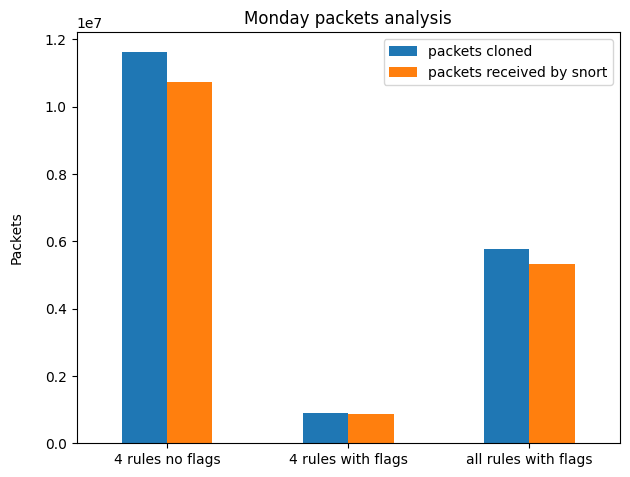

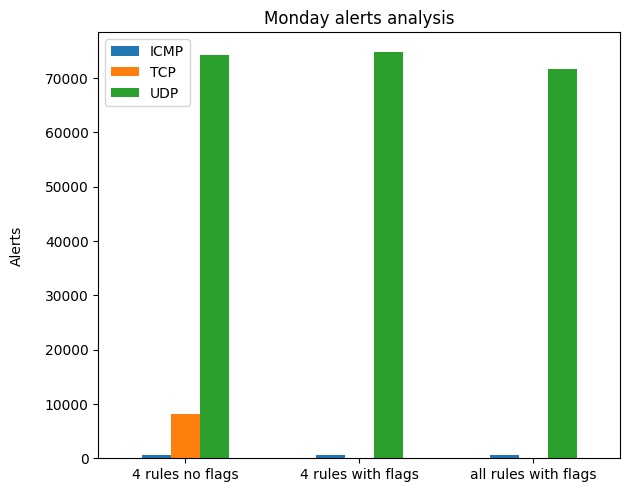

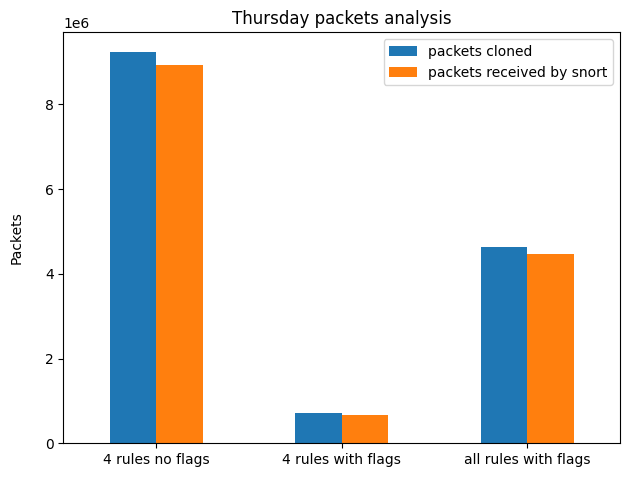

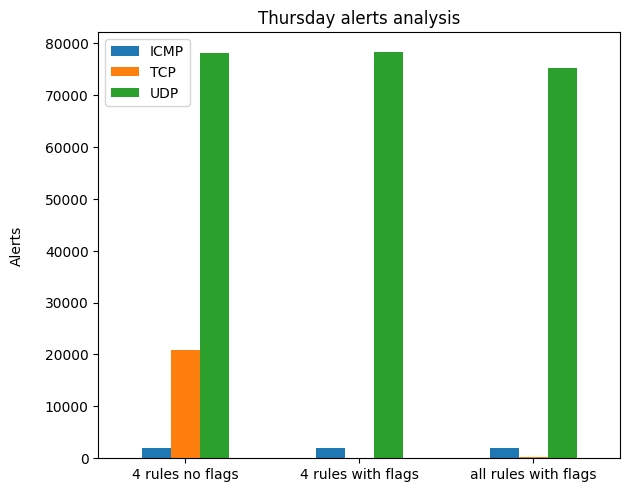

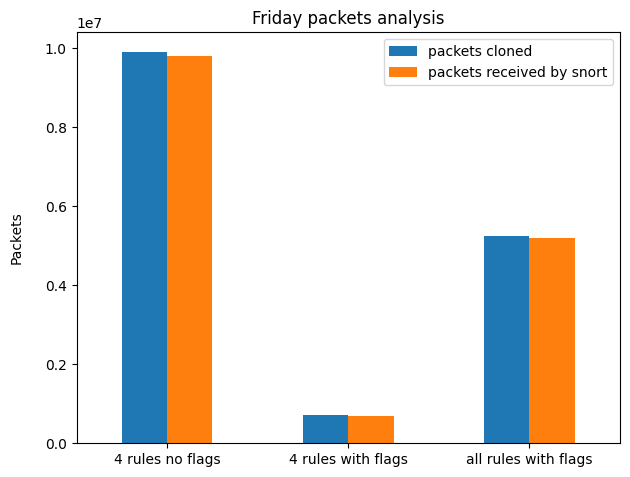

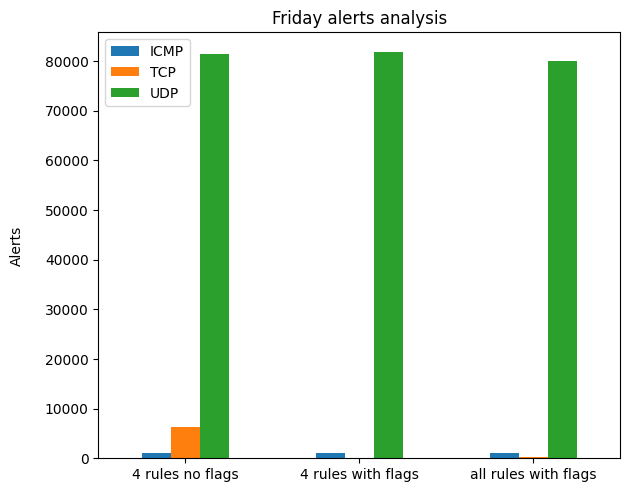

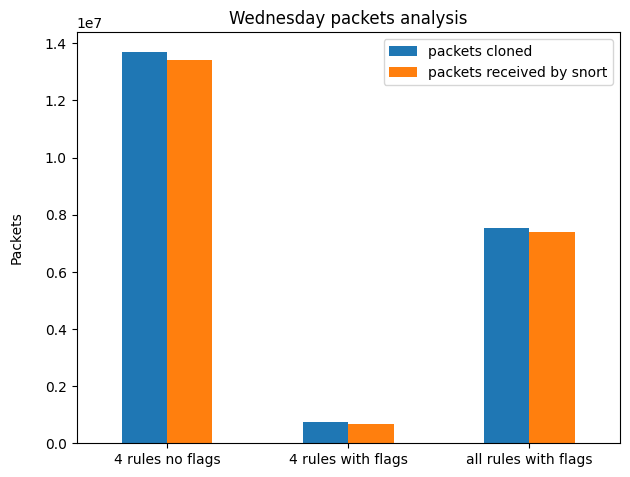

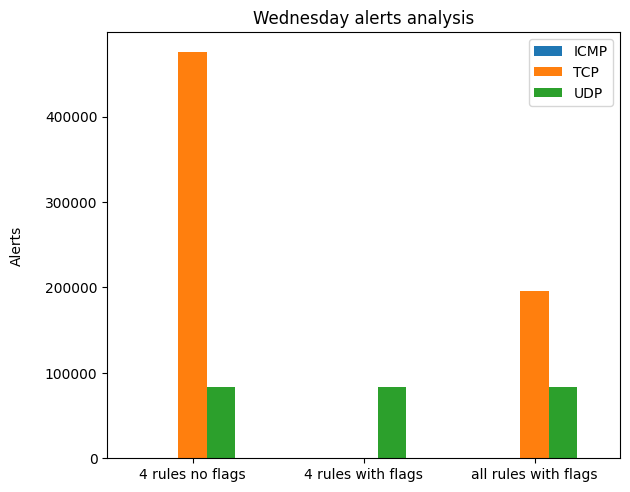

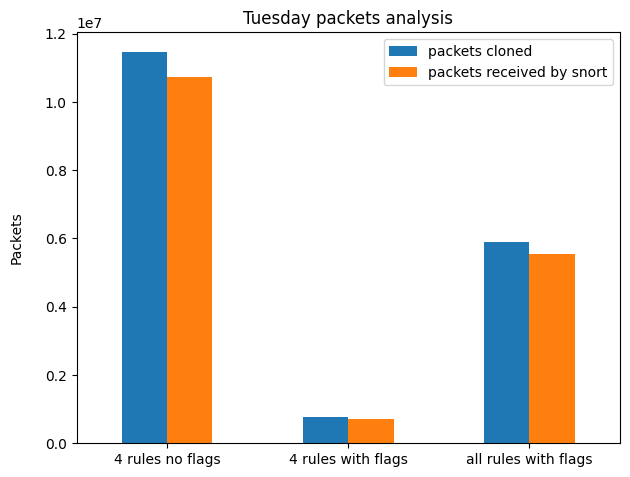

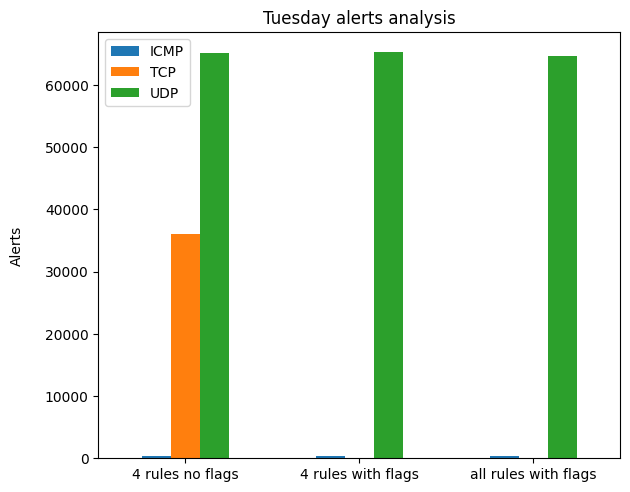

In [8]:
def plot(df, title, ylabel, filename):
    df.set_index('scenario', inplace=True)
    ax = df.plot(kind='bar', rot=0)

    plt.xlabel(xlabel=None)
    plt.ylabel(ylabel, labelpad=15)
    plt.tight_layout()
    plt.title(title)
    plt.savefig(filename)

for pcap in new_df["pcap"].unique():
    title = pcap+" packets analysis"
    filename = "rules_graphs/packets_to_NIDS_"+pcap+".png"
    plot(new_df[new_df["pcap"] == pcap][["scenario", "packets cloned", "packets received by snort"]], title, "Packets", filename)

    title = pcap+" alerts analysis"
    filename = "rules_graphs/alerts_by_protocol_"+pcap+".png"
    plot(new_df[new_df["pcap"] == pcap][["scenario", "ICMP", "TCP", "UDP"]], title, "Alerts", filename)
